In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA, ARIMA
import math
from sklearn.metrics import mean_squared_error
from random import random
import datetime

In [35]:
# from google.colab import drive
# drive.mount('/content/drive')

In [36]:
df = pd.read_excel('/content/patan_final.xlsx')

In [37]:
df.head()

,Date,Arrival,Price
0,2010-01-01,84.8,2755.0
1,2010-01-02,75.8,2750.0
2,2010-01-03,80.3,2752.5
3,2010-01-04,87.4,2750.0
4,2010-01-05,122.1,2770.0


In [38]:
df.set_index('Date', inplace=True)

In [39]:
!pip install pmdarima --quiet

In [40]:
!pip install arch --quiet

In [41]:
# Required Libraries
from pmdarima.arima import auto_arima
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from arch import arch_model
from sklearn.metrics import mean_squared_error

# Load Data
# df = pd.read_excel("C:/Users/ASUS/Downloads/dummy data 16.xlsx")
# df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
# df.set_index('Date', inplace=True)

# Split Data into Train and Test
train = df.iloc[:-100]  # Training data (all except last 10 observations)
test = df.iloc[-100:]  # Test data (last 10 observations)

# Step 1: Fit ARIMA Model Using auto_arima
arima_model = auto_arima(
    train['Price'], start_p=0, d=1, start_q=0,
    max_p=3, max_d=3, max_q=3, start_P=0,
    D=1, start_Q=0, max_P=3, max_D=3,
    max_Q=3, m=7, seasonal=True,
    error_action='warn', trace=True,
    suppress_warnings=True, stepwise=True,
    random_state=20, n_fits=50
)

# Summary of ARIMA model
print("Optimal ARIMA model order:", arima_model.order)
print("Optimal seasonal order:", arima_model.seasonal_order)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=66955.500, Time=0.55 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=64548.142, Time=6.43 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=9.37 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=66059.384, Time=0.83 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=64016.429, Time=16.32 sec
 ARIMA(1,1,0)(3,1,0)[7]             : AIC=63671.564, Time=8.38 sec
 ARIMA(1,1,0)(3,1,1)[7]             : AIC=inf, Time=26.29 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=14.43 sec
 ARIMA(0,1,0)(3,1,0)[7]             : AIC=64348.851, Time=2.45 sec
 ARIMA(2,1,0)(3,1,0)[7]             : AIC=63622.705, Time=11.78 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=63965.614, Time=5.27 sec
 ARIMA(2,1,0)(3,1,1)[7]             : AIC=inf, Time=34.83 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=16.77 sec
 ARIMA(3,1,0)(3,1,0)[7]             : AIC=63599.795, Time=13.77 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=

In [42]:
arima_model.fit(train['Price'])
arima_predictions = arima_model.predict(n_periods=len(test))

In [43]:
# Step 3: Extract Residuals for ARCH Modeling
arima_residuals = train['Price'] - arima_model.predict_in_sample()

# Rescale residuals
residuals_rescaled = arima_residuals / arima_residuals.std()

In [44]:
residuals_rescaled

,0
Date,
2010-01-01,26.672721
2010-01-02,0.026413
2010-01-03,0.015390
2010-01-04,-0.011916
2010-01-05,0.181865
...,...
2024-08-08,0.119669
2024-08-09,-0.164002
2024-08-10,-0.176045


In [45]:
# Step 4: Fit ARCH Model on ARIMA Residuals
from arch import arch_model

# Fit GARCH model on residuals
arch_model_fit = arch_model(residuals_rescaled, vol='GARCH', p=1, q=0, mean='Zero')
arch_result = arch_model_fit.fit(disp="off")
print(arch_result.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -6174.18
Distribution:                  Normal   AIC:                           12352.4
Method:            Maximum Likelihood   BIC:                           12365.5
                                        No. Observations:                 5338
Date:                Wed, Nov 27 2024   Df Residuals:                     5338
Time:                        14:37:15   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.4085  7.036e-02      5.806  6.408e-09 [  0.271,  0.54

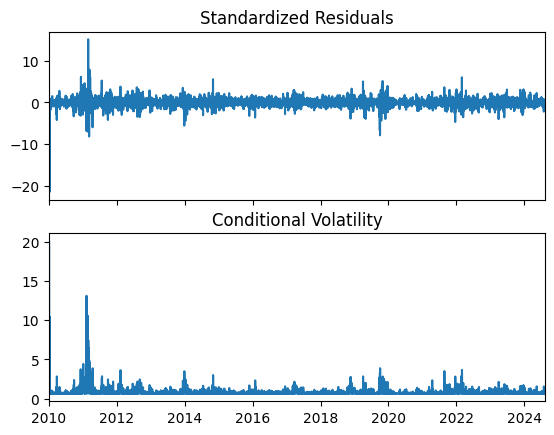

In [46]:
# Step 5: Diagnostic Checking for ARCH Model
# Plot diagnostics
arch_result.plot()
plt.show()

In [47]:
from statsmodels.stats.diagnostic import het_arch

arch_test = het_arch(arch_result.resid)
print("Engle’s ARCH test p-value:", arch_test[1])

Engle’s ARCH test p-value: 2.710696634717226e-293


In [48]:
# Step 6: Generate Predictions Using the ARCH Model
# Forecast the conditional variance (volatility) for the test set
forecast = arch_result.forecast(horizon=len(test))
conditional_volatility = forecast.variance.values[-1]  # Conditional variance for forecast horizon
conditional_volatility

array([0.42254025, 0.64877001, 0.77740872, 0.85055523, 0.89214777,
       0.91579812, 0.92924617, 0.936893  , 0.94124114, 0.94371357,
       0.94511945, 0.94591886, 0.94637342, 0.94663189, 0.94677886,
       0.94686243, 0.94690995, 0.94693697, 0.94695234, 0.94696108,
       0.94696604, 0.94696887, 0.94697047, 0.94697139, 0.94697191,
       0.9469722 , 0.94697237, 0.94697247, 0.94697252, 0.94697255,
       0.94697257, 0.94697258, 0.94697258, 0.94697259, 0.94697259,
       0.94697259, 0.94697259, 0.94697259, 0.94697259, 0.94697259,
       0.94697259, 0.94697259, 0.94697259, 0.94697259, 0.94697259,
       0.94697259, 0.94697259, 0.94697259, 0.94697259, 0.94697259,
       0.94697259, 0.94697259, 0.94697259, 0.94697259, 0.94697259,
       0.94697259, 0.94697259, 0.94697259, 0.94697259, 0.94697259,
       0.94697259, 0.94697259, 0.94697259, 0.94697259, 0.94697259,
       0.94697259, 0.94697259, 0.94697259, 0.94697259, 0.94697259,
       0.94697259, 0.94697259, 0.94697259, 0.94697259, 0.94697

In [49]:
# Combine ARIMA predictions with ARCH volatility
# (If you need confidence intervals, incorporate this volatility measure)
predicted_mean = arima_predictions
predicted_volatility = np.sqrt(conditional_volatility)

In [50]:
# Step 7: Evaluate Model Performance
# Compute RMSE for ARIMA predictions (for the mean process)
rmse_arima = np.sqrt(mean_squared_error(test['Price'], predicted_mean))
print("ARIMA RMSE on Test Set:", rmse_arima)

ARIMA RMSE on Test Set: 218.8572001963829


In [51]:
from sklearn.metrics import mean_squared_error
y_true = test["Price"]
y_pred = arima_predictions

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

# Calculate the range of the target variable
y_range = np.max(y_true) - np.min(y_true)

# Calculate the RMSE as a percentage of the range
rmse_percentage = (rmse / y_range) * 100

print(f'Mean Squared Error (MSE) : {mse:.2f}')
print(f'Root Mean Squared Error (RMSE) : {rmse:.2f}')
print(f'Root Mean Squared Error (RMSE) as a percentage of the range: {rmse_percentage:.2f}%')

Mean Squared Error (MSE) : 47898.47
Root Mean Squared Error (RMSE) : 218.86
Root Mean Squared Error (RMSE) as a percentage of the range: 34.20%


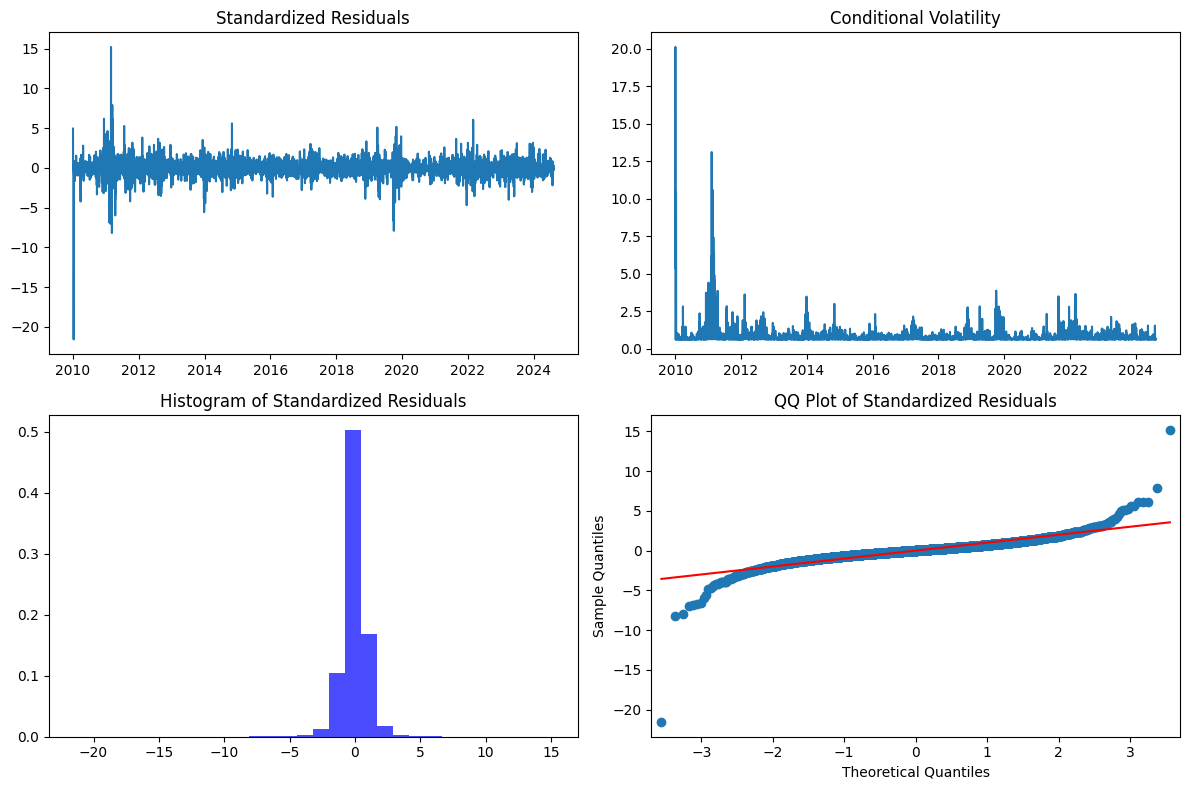

In [52]:
# === PLOT 1: Diagnostic Plots for Residuals ===
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# Standardized Residuals
ax[0, 0].plot(arch_result.std_resid, label="Standardized Residuals")
ax[0, 0].set_title("Standardized Residuals")

# Conditional Volatility
ax[0, 1].plot(arch_result.conditional_volatility, label="Conditional Volatility")
ax[0, 1].set_title("Conditional Volatility")

# Histogram of Standardized Residuals
ax[1, 0].hist(arch_result.std_resid, bins=30, density=True, alpha=0.7, color='blue')
ax[1, 0].set_title("Histogram of Standardized Residuals")

# QQ Plot
from statsmodels.graphics.gofplots import qqplot
qqplot(arch_result.std_resid, line='s', ax=ax[1, 1])
ax[1, 1].set_title("QQ Plot of Standardized Residuals")

plt.tight_layout()
plt.show()

In [63]:
# Generate Forecast Beyond Test Data

# Step 1: Generate Predictions Using ARIMA (Test + Forecast)
# Number of periods in the test data
n_test_periods = len(test)

# Forecast horizon beyond the test data
forecast_horizon = 100  # Number of future periods to forecast

# Total periods to predict (test + forecast)
total_periods = n_test_periods + forecast_horizon

# Generate predictions (ARIMA)
total_forecast = arima_model.predict(n_periods=total_periods)

# Separate test predictions and forecasts
test_predictions = total_forecast[:n_test_periods]
forecast_values = total_forecast[n_test_periods:]

In [64]:
forecast_values

,0
2024-11-21,6286.528861
2024-11-22,6280.268918
2024-11-23,6250.695962
2024-11-24,6248.057457
2024-11-25,6230.151949
...,...
2025-02-24,6464.878069
2025-02-25,6463.880334
2025-02-26,6502.770751
2025-02-27,6539.328312


In [65]:
# Forecast Conditional Volatility Using GARCH

arch_forecast = arch_result.forecast(horizon=total_periods)

# Extract variance and standard deviation
conditional_variance = arch_forecast.variance.values[-1]  # Get forecasted variance
conditional_volatility = np.sqrt(conditional_variance)

# Step: Compute GARCH-Enhanced Confidence Intervals
alpha = 0.05  # 95% confidence interval
z_score = norm.ppf(1 - alpha / 2)

# Confidence intervals for test predictions
test_upper_bound = test_predictions + z_score * conditional_volatility[:n_test_periods]
test_lower_bound = test_predictions - z_score * conditional_volatility[:n_test_periods]


# Confidence intervals for forecast values
forecast_upper_bound = forecast_values + z_score * conditional_volatility[n_test_periods:]
forecast_lower_bound = forecast_values - z_score * conditional_volatility[n_test_periods:]

In [66]:
forecast_lower_bound

,0
2024-11-21,6284.621571
2024-11-22,6278.361628
2024-11-23,6248.788672
2024-11-24,6246.150166
2024-11-25,6228.244659
...,...
2025-02-24,6462.970779
2025-02-25,6461.973044
2025-02-26,6500.863460
2025-02-27,6537.421022


In [67]:
# Create DataFrames for test predictions and forecasts
test_pred_df = pd.DataFrame({
    "Test Prediction": test_predictions,
    "Lower Bound": test_lower_bound,
    "Upper Bound": test_upper_bound
}, index=test.index)

In [68]:
#Print Results
print("Test Predictions with Confidence Intervals:")
print(test_pred_df)

Test Predictions with Confidence Intervals:
            Test Prediction  Lower Bound  Upper Bound
Date                                                 
2024-08-13      5976.070723  5974.796686  5977.344760
2024-08-14      5998.636805  5997.058128  6000.215483
2024-08-15      6020.708996  6018.980880  6022.437111
2024-08-16      6019.441288  6017.633700  6021.248875
2024-08-17      5991.360058  5989.508802  5993.211314
...                     ...          ...          ...
2024-11-16      6232.659878  6230.752588  6234.567169
2024-11-17      6230.001160  6228.093869  6231.908450
2024-11-18      6212.098103  6210.190813  6214.005393
2024-11-19      6211.061470  6209.154180  6212.968760
2024-11-20      6249.965214  6248.057924  6251.872504

[100 rows x 3 columns]


In [69]:
forecast_index = pd.date_range(
    start=test.index[-1] + pd.Timedelta(days=1),
    periods=forecast_horizon,
    freq='D' # Adjust frequency if needed
)

forecast_df = pd.DataFrame({
    "Forecast": forecast_values,
    "Lower Bound": forecast_lower_bound,
    "Upper Bound": forecast_upper_bound
}, index=forecast_index)

In [70]:
print("\nForecasts with Confidence Intervals:")
print(forecast_df)


Forecasts with Confidence Intervals:
               Forecast  Lower Bound  Upper Bound
2024-11-21  6286.528861  6284.621571  6288.436152
2024-11-22  6280.268918  6278.361628  6282.176208
2024-11-23  6250.695962  6248.788672  6252.603252
2024-11-24  6248.057457  6246.150166  6249.964747
2024-11-25  6230.151949  6228.244659  6232.059240
...                 ...          ...          ...
2025-02-24  6464.878069  6462.970779  6466.785360
2025-02-25  6463.880334  6461.973044  6465.787625
2025-02-26  6502.770751  6500.863460  6504.678041
2025-02-27  6539.328312  6537.421022  6541.235603
2025-02-28  6533.060837  6531.153547  6534.968128

[100 rows x 3 columns]


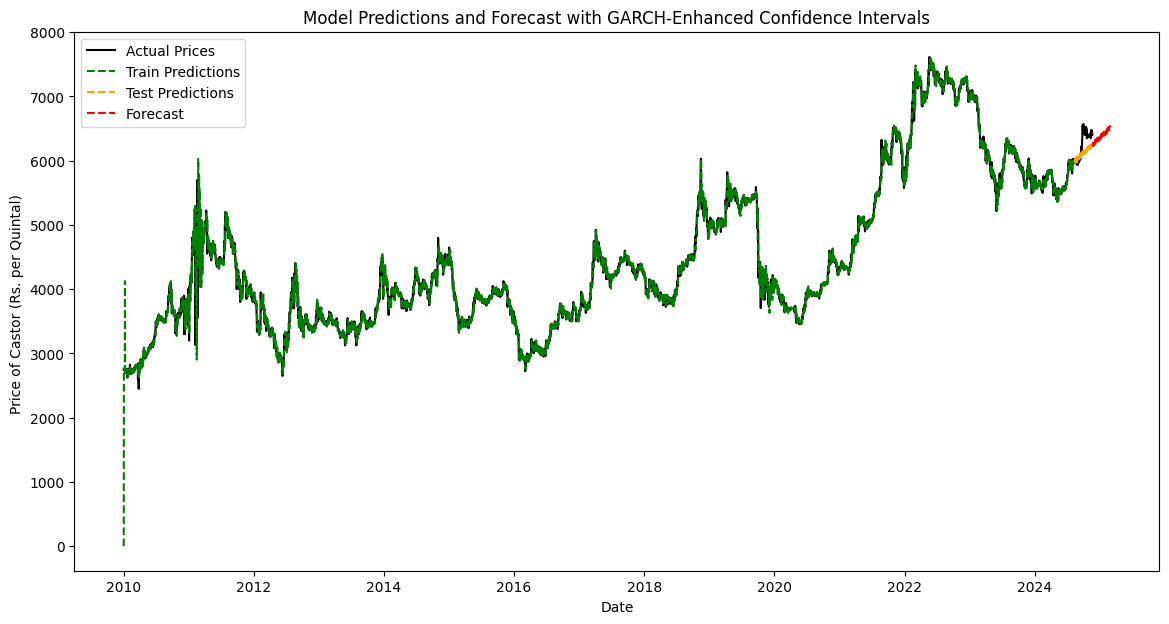

In [71]:
# Step 7: Plot Results
plt.figure(figsize=(14, 7))

# Actual prices
plt.plot(df.index, df['Price'], color='black', label="Actual Prices")
# Train predictions
train_predictions = arima_model.predict_in_sample()
plt.plot(train.index, train_predictions, color='green', linestyle='--', label="Train Predictions")
# Test predictions
plt.plot(test.index, test_predictions, color='orange', linestyle='--', label="Test Predictions")
# Forecast values
plt.plot(forecast_index, forecast_df["Forecast"], color='red', linestyle='--', label="Forecast")

# Add labels, title, and legend
plt.title("Model Predictions and Forecast with GARCH-Enhanced Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("Price of Castor (Rs. per Quintal) ")
plt.legend()
plt.show()

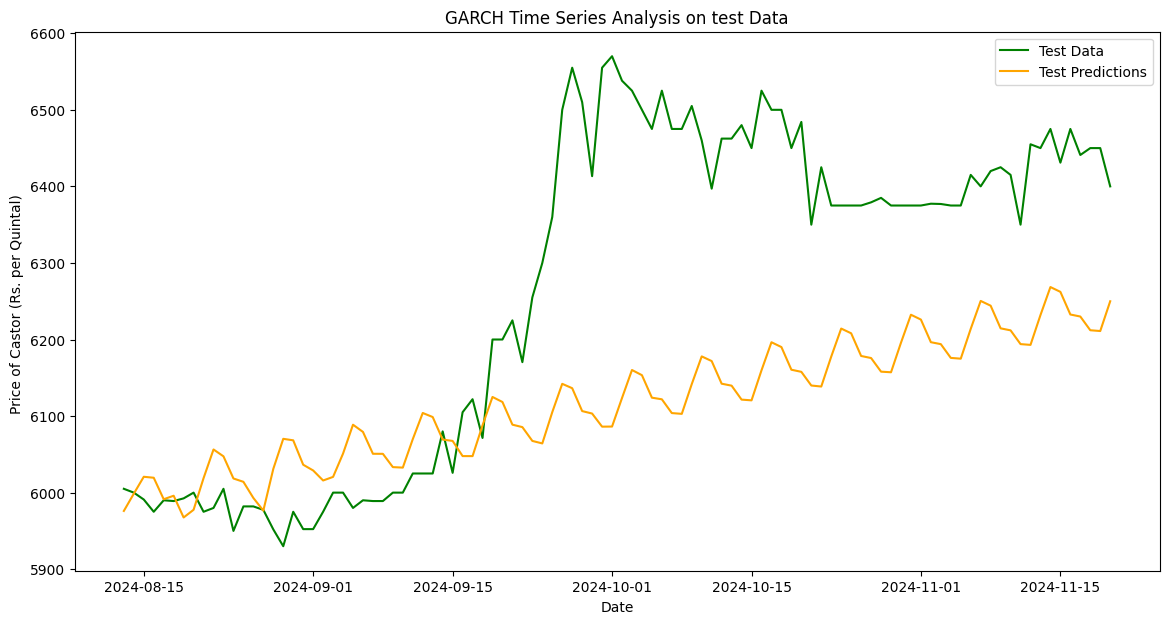

In [62]:
plt.figure(figsize=(14, 7))
plt.plot(test.index, test['Price'], label='Test Data', color='green')
plt.plot(test.index, test_predictions, color='orange', label="Test Predictions")
plt.title("GARCH Time Series Analysis on test Data")
plt.xlabel("Date")
plt.ylabel("Price of Castor (Rs. per Quintal) ")
plt.legend()
plt.show()